In [ ]:
# ensemble hard voting method 

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

In [20]:
#using existing model predictions
# record start time
start_time = time.time()

# load existing models predictions
print("\n Loading existing model predictions...")

rf_path = "/Users/xingzhidu/Desktop/ML/ML A2/submission_deep_features.csv"
svm_path = "/Users/xingzhidu/Desktop/ML/ML A2/svm_submission_deep_features.csv" 
cnn_path = "/Users/xingzhidu/Desktop/ML/ML A2/cnn_submission_efficient_resnet50.csv"

# load predictions
print("   Loading Random Forest predictions...")
rf_predictions = pd.read_csv(rf_path)
print(f"    RF predictions: {rf_predictions.shape}")

print("   Loading SVM predictions...")
svm_predictions = pd.read_csv(svm_path)
print(f"    SVM predictions: {svm_predictions.shape}")

print("   Loading CNN predictions...")
cnn_predictions = pd.read_csv(cnn_path)
print(f"    CNN predictions: {cnn_predictions.shape}")

# verify all files have same structure
print(f"\n Verification:")
print(f"   RF columns: {list(rf_predictions.columns)}")
print(f"   SVM columns: {list(svm_predictions.columns)}")
print(f"   CNN columns: {list(cnn_predictions.columns)}")

# load original test metadata to preserve order
print("   Loading original test metadata to preserve order...")
test_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/test_metadata.csv")
print(f"    Test metadata: {test_metadata.shape}")
print(f"   Original test order preserved!")

# check if IDs match
rf_ids = set(rf_predictions['id'])
svm_ids = set(svm_predictions['id'])
cnn_ids = set(cnn_predictions['id'])
test_ids = set(test_metadata['id'])

print(f"\n   ID matching check:")
print(f"   All match test: {test_ids == rf_ids == svm_ids == cnn_ids}")

# use merge to preserve test file order instead of sorting
aligned_data = test_metadata[['id']].copy()

# merge each model's predictions to preserve order
aligned_data = aligned_data.merge(rf_predictions[['id', 'ClassId']], on='id', how='left', suffixes=('', '_rf'))
aligned_data.rename(columns={'ClassId': 'RF_pred'}, inplace=True)

aligned_data = aligned_data.merge(svm_predictions[['id', 'ClassId']], on='id', how='left', suffixes=('', '_svm'))
aligned_data.rename(columns={'ClassId': 'SVM_pred'}, inplace=True)

aligned_data = aligned_data.merge(cnn_predictions[['id', 'ClassId']], on='id', how='left', suffixes=('', '_cnn'))
aligned_data.rename(columns={'ClassId': 'CNN_pred'}, inplace=True)

print(f"   Final aligned data: {aligned_data.shape}")

# check for any missing predictions
missing_rf = aligned_data['RF_pred'].isnull().sum()
missing_svm = aligned_data['SVM_pred'].isnull().sum()
missing_cnn = aligned_data['CNN_pred'].isnull().sum()

if missing_rf > 0 or missing_svm > 0 or missing_cnn > 0:
    print(f"    Missing predictions - RF: {missing_rf}, SVM: {missing_svm}, CNN: {missing_cnn}")
else:
    print(f"    No missing predictions - all models aligned well!")


 Loading existing model predictions...
   Loading Random Forest predictions...
    RF predictions: (2353, 2)
   Loading SVM predictions...
    SVM predictions: (2353, 2)
   Loading CNN predictions...
    CNN predictions: (2353, 2)

 Verification:
   RF columns: ['id', 'ClassId']
   SVM columns: ['id', 'ClassId']
   CNN columns: ['id', 'ClassId']
   Loading original test metadata to preserve order...
    Test metadata: (2353, 3)
   Original test order preserved!

   ID matching check:
   All match test: True
   Final aligned data: (2353, 4)
    No missing predictions - all models aligned well!


In [22]:
# individual model analysis
def analyze_predictions(predictions_df, model_name):
    """Analyze individual model predictions"""
    class_counts = predictions_df['ClassId'].value_counts().sort_index()
    print(f"   {model_name}:")
    print(f"      Predicted classes: {len(class_counts)} unique classes")
    print(f"      Most predicted class: {class_counts.idxmax()} ({class_counts.max()} times)")
    print(f"      Least predicted class: {class_counts.idxmin()} ({class_counts.min()} times)")
    print(f"      Prediction range: {predictions_df['ClassId'].min()} - {predictions_df['ClassId'].max()}")
    return class_counts

rf_class_counts = analyze_predictions(rf_predictions, "Random Forest")
svm_class_counts = analyze_predictions(svm_predictions, "SVM")
cnn_class_counts = analyze_predictions(cnn_predictions, "CNN")

# model agreement analysis
# create combined dataframe for analysis
combined_df = pd.DataFrame({
    'id': rf_predictions['id'],
    'RF_pred': rf_predictions['ClassId'],
    'SVM_pred': svm_predictions['ClassId'],
    'CNN_pred': cnn_predictions['ClassId']
})

# calculate agreement statistics
print("   Agreement Statistics:")

# all three models agree
all_agree = (combined_df['RF_pred'] == combined_df['SVM_pred']) & \
           (combined_df['SVM_pred'] == combined_df['CNN_pred'])
all_agree_count = all_agree.sum()
all_agree_pct = all_agree_count / len(combined_df) * 100

print(f"      All 3 models agree: {all_agree_count}/{len(combined_df)} ({all_agree_pct:.1f}%)")

# pairwise agreements
rf_svm_agree = (combined_df['RF_pred'] == combined_df['SVM_pred']).sum()
rf_cnn_agree = (combined_df['RF_pred'] == combined_df['CNN_pred']).sum()
svm_cnn_agree = (combined_df['SVM_pred'] == combined_df['CNN_pred']).sum()

print(f"      RF-SVM agree: {rf_svm_agree}/{len(combined_df)} ({rf_svm_agree/len(combined_df)*100:.1f}%)")
print(f"      RF-CNN agree: {rf_cnn_agree}/{len(combined_df)} ({rf_cnn_agree/len(combined_df)*100:.1f}%)")
print(f"      SVM-CNN agree: {svm_cnn_agree}/{len(combined_df)} ({svm_cnn_agree/len(combined_df)*100:.1f}%)")

# no models agree (all different)
no_agree = (combined_df['RF_pred'] != combined_df['SVM_pred']) & \
          (combined_df['RF_pred'] != combined_df['CNN_pred']) & \
          (combined_df['SVM_pred'] != combined_df['CNN_pred'])
no_agree_count = no_agree.sum()
no_agree_pct = no_agree_count / len(combined_df) * 100

print(f"      No models agree: {no_agree_count}/{len(combined_df)} ({no_agree_pct:.1f}%)")

# using the hard voting ensemble
def hard_voting_ensemble(rf_pred, svm_pred, cnn_pred):
    """
    perform hard voting (majority vote) among three predictions
    """
    ensemble_predictions = []
    
    for i in range(len(rf_pred)):
        # get predictions from all models
        votes = [rf_pred.iloc[i], svm_pred.iloc[i], cnn_pred.iloc[i]]
        
        # count votes
        vote_counts = Counter(votes)
        
        # get majority vote (most common prediction)
        majority_vote = vote_counts.most_common(1)[0][0]
        
        # in case of tie (shouldn't happen with 3 models), use first model's prediction
        ensemble_predictions.append(majority_vote)
    
    return ensemble_predictions

# perform hard voting
print("   Computing majority votes...")
ensemble_predictions = hard_voting_ensemble(
    combined_df['RF_pred'], 
    combined_df['SVM_pred'], 
    combined_df['CNN_pred']
)

# create ensemble submission dataframe
ensemble_df = pd.DataFrame({
    'id': combined_df['id'],
    'ClassId': ensemble_predictions
})

print(f"    Ensemble predictions computed!")
print(f"   Ensemble shape: {ensemble_df.shape}")

# to do the ensemble analysis
# analyze ensemble predictions
ensemble_class_counts = analyze_predictions(ensemble_df, "Ensemble")

# compare ensemble to individual models
print(f"\n   Ensemble vs Individual Models:")

# how often does ensemble match each model?
rf_match = (ensemble_df['ClassId'] == combined_df['RF_pred']).sum()
svm_match = (ensemble_df['ClassId'] == combined_df['SVM_pred']).sum()
cnn_match = (ensemble_df['ClassId'] == combined_df['CNN_pred']).sum()

print(f"      Ensemble matches RF: {rf_match}/{len(ensemble_df)} ({rf_match/len(ensemble_df)*100:.1f}%)")
print(f"      Ensemble matches SVM: {svm_match}/{len(ensemble_df)} ({svm_match/len(ensemble_df)*100:.1f}%)")
print(f"      Ensemble matches CNN: {cnn_match}/{len(ensemble_df)} ({cnn_match/len(ensemble_df)*100:.1f}%)")

# cases where ensemble differs from all individual models (shouldn't happen with hard voting)
ensemble_unique = ((ensemble_df['ClassId'] != combined_df['RF_pred']) & 
                  (ensemble_df['ClassId'] != combined_df['SVM_pred']) & 
                  (ensemble_df['ClassId'] != combined_df['CNN_pred'])).sum()

print(f"      Ensemble unique (differs from all): {ensemble_unique}/{len(ensemble_df)} ({ensemble_unique/len(ensemble_df)*100:.1f}%)")

# to do the voting pattern analysis
voting_patterns = []
for i in range(len(combined_df)):
    rf_vote = combined_df['RF_pred'].iloc[i]
    svm_vote = combined_df['SVM_pred'].iloc[i]
    cnn_vote = combined_df['CNN_pred'].iloc[i]
    ensemble_vote = ensemble_df['ClassId'].iloc[i]
    
    # determine voting pattern
    if rf_vote == svm_vote == cnn_vote:
        pattern = "Unanimous"
    elif rf_vote == svm_vote == ensemble_vote:
        pattern = "RF+SVM majority"
    elif rf_vote == cnn_vote == ensemble_vote:
        pattern = "RF+CNN majority"
    elif svm_vote == cnn_vote == ensemble_vote:
        pattern = "SVM+CNN majority"
    else:
        pattern = "Other"
    
    voting_patterns.append(pattern)

# count voting patterns
pattern_counts = Counter(voting_patterns)
print("   Voting Pattern Distribution:")
for pattern, count in pattern_counts.most_common():
    pct = count / len(voting_patterns) * 100
    print(f"      {pattern}: {count} ({pct:.1f}%)")

   Random Forest:
      Predicted classes: 43 unique classes
      Most predicted class: 38 (177 times)
      Least predicted class: 37 (4 times)
      Prediction range: 0 - 42
   SVM:
      Predicted classes: 43 unique classes
      Most predicted class: 1 (143 times)
      Least predicted class: 0 (11 times)
      Prediction range: 0 - 42
   CNN:
      Predicted classes: 43 unique classes
      Most predicted class: 4 (297 times)
      Least predicted class: 0 (5 times)
      Prediction range: 0 - 42
   Agreement Statistics:
      All 3 models agree: 1525/2353 (64.8%)
      RF-SVM agree: 1909/2353 (81.1%)
      RF-CNN agree: 1571/2353 (66.8%)
      SVM-CNN agree: 1773/2353 (75.4%)
      No models agree: 150/2353 (6.4%)
   Computing majority votes...
    Ensemble predictions computed!
   Ensemble shape: (2353, 2)
   Ensemble:
      Predicted classes: 43 unique classes
      Most predicted class: 38 (142 times)
      Least predicted class: 0 (6 times)
      Prediction range: 0 - 42

  

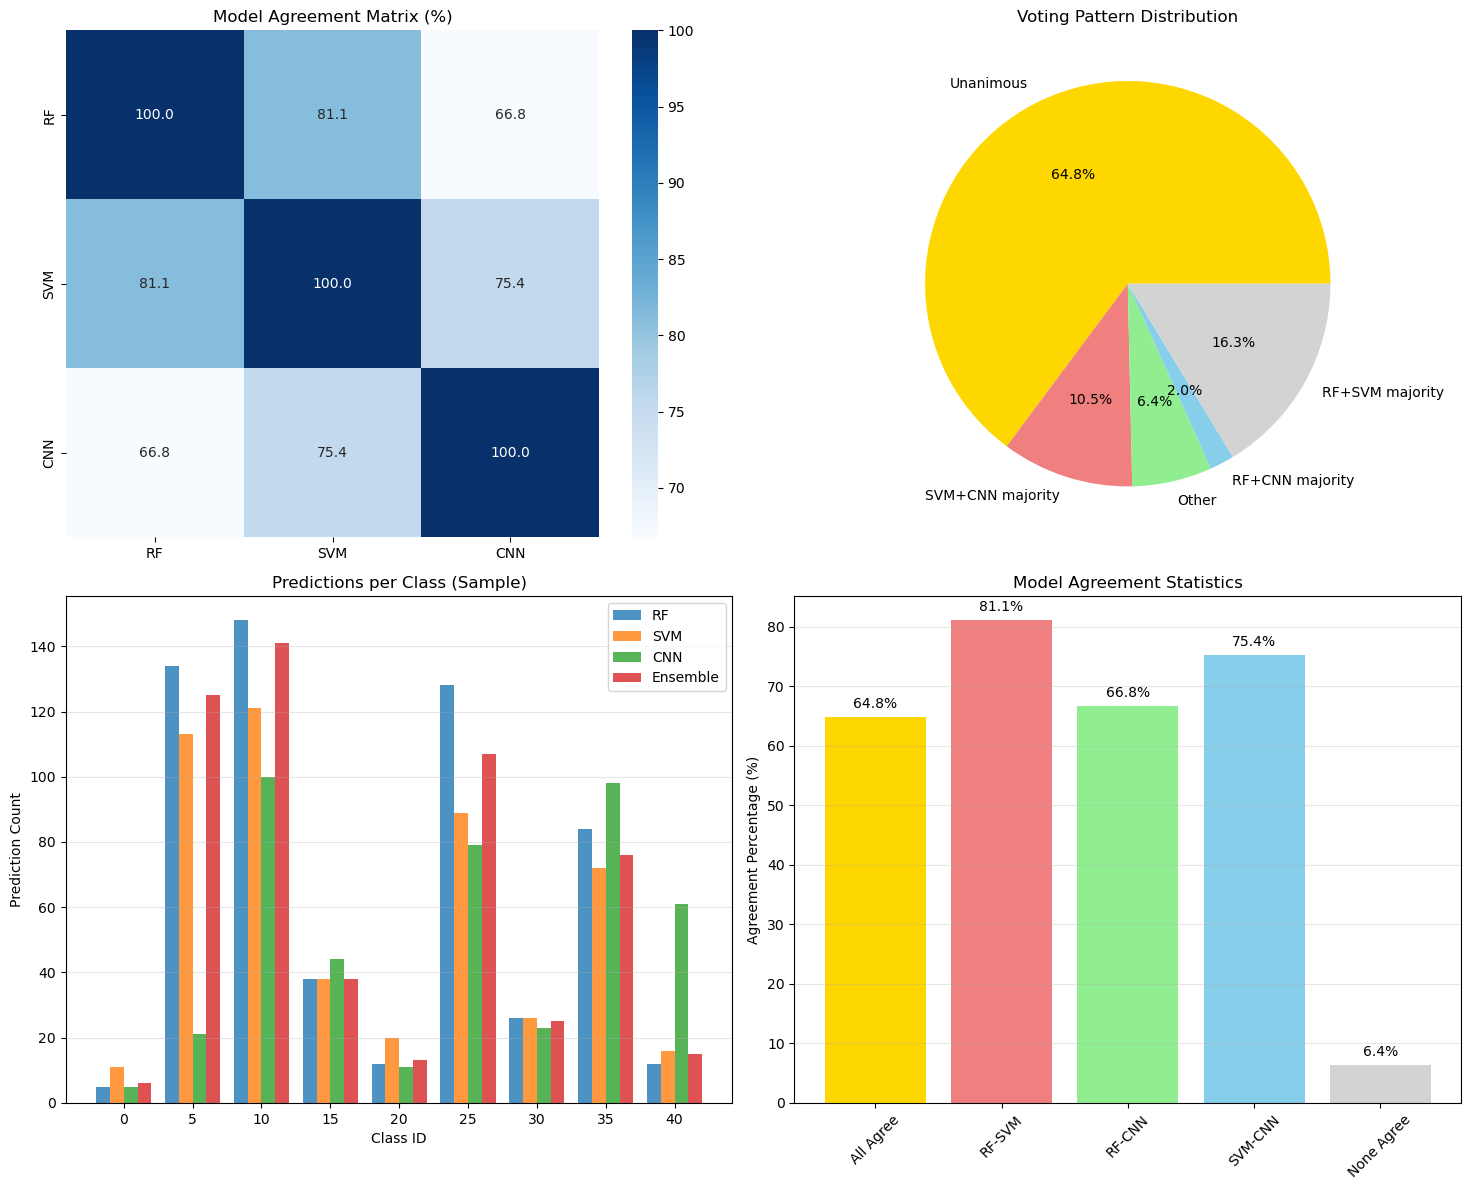

In [24]:
#create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. model Agreement Heatmap
agreement_matrix = np.array([
    [100, rf_svm_agree/len(combined_df)*100, rf_cnn_agree/len(combined_df)*100],
    [rf_svm_agree/len(combined_df)*100, 100, svm_cnn_agree/len(combined_df)*100],
    [rf_cnn_agree/len(combined_df)*100, svm_cnn_agree/len(combined_df)*100, 100]
])

sns.heatmap(agreement_matrix, 
           xticklabels=['RF', 'SVM', 'CNN'],
           yticklabels=['RF', 'SVM', 'CNN'],
           annot=True, fmt='.1f', cmap='Blues',
           ax=ax1)
ax1.set_title('Model Agreement Matrix (%)')

# 2. voting Patterns
patterns = list(pattern_counts.keys())
pattern_vals = list(pattern_counts.values())
colors = ['gold', 'lightcoral', 'lightgreen', 'skyblue', 'lightgray']
ax2.pie(pattern_vals, labels=patterns, autopct='%1.1f%%', colors=colors[:len(patterns)])
ax2.set_title('Voting Pattern Distribution')

# 3. class Prediction Comparison
classes_to_plot = list(range(0, 43, 5))  # Every 5th class for readability
rf_counts_subset = [rf_class_counts.get(c, 0) for c in classes_to_plot]
svm_counts_subset = [svm_class_counts.get(c, 0) for c in classes_to_plot]
cnn_counts_subset = [cnn_class_counts.get(c, 0) for c in classes_to_plot]
ensemble_counts_subset = [ensemble_class_counts.get(c, 0) for c in classes_to_plot]

x = np.arange(len(classes_to_plot))
width = 0.2

ax3.bar(x - 1.5*width, rf_counts_subset, width, label='RF', alpha=0.8)
ax3.bar(x - 0.5*width, svm_counts_subset, width, label='SVM', alpha=0.8)
ax3.bar(x + 0.5*width, cnn_counts_subset, width, label='CNN', alpha=0.8)
ax3.bar(x + 1.5*width, ensemble_counts_subset, width, label='Ensemble', alpha=0.8)

ax3.set_xlabel('Class ID')
ax3.set_ylabel('Prediction Count')
ax3.set_title('Predictions per Class (Sample)')
ax3.set_xticks(x)
ax3.set_xticklabels(classes_to_plot)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. agreement Statistics Bar Chart
agreement_data = [
    ('All Agree', all_agree_pct),
    ('RF-SVM', rf_svm_agree/len(combined_df)*100),
    ('RF-CNN', rf_cnn_agree/len(combined_df)*100),
    ('SVM-CNN', svm_cnn_agree/len(combined_df)*100),
    ('None Agree', no_agree_pct)
]

labels, values = zip(*agreement_data)
bars = ax4.bar(labels, values, color=['gold', 'lightcoral', 'lightgreen', 'skyblue', 'lightgray'])
ax4.set_ylabel('Agreement Percentage (%)')
ax4.set_title('Model Agreement Statistics')
ax4.grid(axis='y', alpha=0.3)

# add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ensemble_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# save ensemble submission
ensemble_filename = "ensemble_submission_hard_voting.csv"
ensemble_df.to_csv(ensemble_filename, index=False)

In [25]:
# summary
print(f"\n Agreement Analysis:")
print(f" All models agree: {all_agree_pct:.1f}%")
print(f" Best pairwise agreement: {max(rf_svm_agree, rf_cnn_agree, svm_cnn_agree)/len(combined_df)*100:.1f}%")
print(f" No agreement: {no_agree_pct:.1f}%")


 Agreement Analysis:
 All models agree: 64.8%
 Best pairwise agreement: 81.1%
 No agreement: 6.4%
